In [39]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Classifiers
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Optimization
from hyperopt import fmin, tpe, hp, STATUS_OK

# Seeding
import random
random.seed(42)  # Set random seed for Python
np.random.seed(42)  # Set random seed for NumPy

In [40]:
train = pd.read_csv('../data_format1 - Copy/train_format1.csv')
user_info = pd.read_csv('../data_format1 - Copy/user_info_format1.csv')
test = pd.read_csv('../data_format1 - Copy/test_format1.csv')

In [41]:
train.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [42]:
test.head()

,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [43]:
user_log = pd.read_csv('../data_format1/user_log_format1.csv')
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%m%d', errors='coerce')
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661,1900-08-29,0
1,328862,844400,1271,2882,2661,1900-08-29,0
2,328862,575153,1271,2882,2661,1900-08-29,0
3,328862,996875,1271,2882,2661,1900-08-29,0
4,328862,1086186,1271,1253,1049,1900-08-29,0


In [44]:
# Extract meaningful features
user_log['day_of_week'] = user_log['time_stamp'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
user_log['month'] = user_log['time_stamp'].dt.month            # Month of the action


In [45]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [46]:
# Merge user info with train dataset
train = train.merge(user_info, on='user_id', how='left')
test = test.merge(user_info, on='user_id', how='left')
train.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6.0,0.0
1,34176,121,0,6.0,0.0
2,34176,4356,1,6.0,0.0
3,34176,2217,0,6.0,0.0
4,230784,4818,0,0.0,0.0


# User Based Features

In [47]:
# Aggregating time-based features
time_features = user_log.groupby('user_id').agg({
    'day_of_week': lambda x: x.value_counts().idxmax(),  # Most common interaction day
    'month': lambda x: x.value_counts().idxmax()         # Most active month
}).reset_index()

# Rename columns for clarity
time_features.columns = ['user_id', 'most_active_day', 'most_active_month']
time_features.head()

,user_id,most_active_day,most_active_month
0,102269,6,11
1,139859,6,11
2,149002,6,11
3,186568,6,10
4,234512,6,11


In [48]:
#  user-level features
user_features = user_log.groupby('user_id').agg({
    'item_id': 'count',       # Total interactions
    'cat_id': 'nunique',      # Unique categories
    'seller_id': 'nunique',   # Unique merchants
    'brand_id': 'nunique',    # Unique brands
    'time_stamp': 'nunique',  # Active days
}).reset_index()

# Rename columns for clarity
user_features.rename(columns={
    'item_id': 'total_interactions',
    'cat_id': 'unique_categories',
    'seller_id': 'unique_merchants',
    'brand_id': 'unique_brands',
    'time_stamp': 'active_days'
}, inplace=True)

user_features = user_features.merge(time_features, how='left', on='user_id')
user_features.head()

,user_id,total_interactions,unique_categories,unique_merchants,unique_brands,active_days,most_active_day,most_active_month
0,102269,36,12,14,14,8,6,11
1,139859,43,22,24,23,17,6,11
2,149002,20,10,9,9,5,6,11
3,186568,241,66,75,74,48,6,10
4,234512,56,18,21,20,11,6,11


In [49]:
# Add action type-specific counts
action_counts = user_log.groupby('user_id')['action_type'].value_counts().unstack(fill_value=0).reset_index()
action_counts.columns = ['user_id', 'total_clicks', 'total_carts', 'total_purchases', 'total_favs']

# Merge action counts with general features
user_features = user_features.merge(action_counts, on='user_id', how='left')

# Add ratio and conversion features
user_features['total_actions'] = user_features[['total_clicks', 'total_carts', 'total_purchases', 'total_favs']].sum(axis=1)
user_features['click_ratio'] = user_features['total_clicks'] / user_features['total_actions']
user_features['purchase_ratio'] = user_features['total_purchases'] / user_features['total_actions']
user_features['add_to_cart_ratio'] = user_features['total_carts'] / user_features['total_actions']
user_features['favorite_ratio'] = user_features['total_favs'] / user_features['total_actions']

# Direct abandonment rates
user_features['cart_abandonment_rate'] = np.where(
    user_features['total_carts'] > 0,
    (user_features['total_carts'] - user_features['total_purchases']) / user_features['total_carts'],
    0
)

user_features['fav_abandonment_rate'] = np.where(
    user_features['total_favs'] > 0,
    (user_features['total_favs'] - user_features['total_purchases']) / user_features['total_favs'],
    0
)

# Weighted abandonment rates (relative to total actions)
user_features['weighted_cart_abandonment_rate'] = (
    (user_features['total_carts'] - user_features['total_purchases']) / user_features['total_actions']
)

user_features['weighted_fav_abandonment_rate'] = (
    (user_features['total_favs'] - user_features['total_purchases']) / user_features['total_actions']
)

user_features.head()

ValueError: Length mismatch: Expected axis has 4 elements, new values have 5 elements

In [12]:
# Diversity features
user_features['category_preference'] = user_log.groupby('user_id')['cat_id'].apply(lambda x: x.value_counts(normalize=True).max()).values
user_features['merchant_preference'] = user_log.groupby('user_id')['seller_id'].apply(lambda x: x.value_counts(normalize=True).max()).values
user_features['brand_preference'] = user_log.groupby('user_id')['brand_id'].apply(lambda x: x.value_counts(normalize=True).max()).values

# Behavioral patterns
user_features['action_entropy'] = user_log.groupby('user_id')['action_type'].apply(
    lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True))))
).values

# Repeat behavior features
user_features['repeat_category_ratio'] = user_log.groupby('user_id')['cat_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

user_features['repeat_brand_ratio'] = user_log.groupby('user_id')['brand_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

user_features['repeat_merchant_ratio'] = user_log.groupby('user_id')['seller_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

# Check final features
user_features.head()


,user_id,total_interactions,unique_categories,unique_merchants,unique_brands,active_days,most_active_day,most_active_month,total_clicks,total_carts,...,fav_abandonment_rate,weighted_cart_abandonment_rate,weighted_fav_abandonment_rate,category_preference,merchant_preference,brand_preference,action_entropy,repeat_category_ratio,repeat_brand_ratio,repeat_merchant_ratio
0,1,33,6,9,9,5,6,11,27,0,...,0.0,-0.181818,-0.181818,0.424242,0.424242,0.424242,0.684038,0.151515,0.121212,0.121212
1,2,63,14,14,15,9,1,6,47,0,...,-6.0,-0.222222,-0.190476,0.317460,0.412698,0.317460,0.955555,0.126984,0.111111,0.095238
2,3,68,19,23,22,13,4,11,63,0,...,-3.0,-0.058824,-0.044118,0.161765,0.220588,0.235294,0.432042,0.205882,0.161765,0.161765
3,4,50,13,12,12,10,6,11,49,0,...,0.0,-0.020000,-0.020000,0.460000,0.500000,0.500000,0.141441,0.100000,0.120000,0.120000
4,5,173,40,56,59,30,6,10,150,0,...,-0.3,-0.075145,-0.017341,0.121387,0.104046,0.104651,0.696780,0.167630,0.156069,0.150289


<!-- ## Merchant based Features -->

# Merchant Based Features

In [13]:
# Base merchant-level aggregation
merchant_features = user_log.groupby('seller_id').agg({
    'user_id': 'nunique',  # Total unique users
    'item_id': 'count',    # Total interactions
    'cat_id': 'nunique',   # Unique categories
    'brand_id': 'nunique', # Unique brands
}).reset_index()

# Rename columns for clarity
merchant_features.rename(columns={
    'seller_id': 'merchant_id',
    'user_id': 'total_users',
    'item_id': 'total_interactions',
    'cat_id': 'unique_categories',
    'brand_id': 'unique_brands'
}, inplace=True)

# User engagement metrics
merchant_user_counts = user_log.groupby('seller_id')['user_id'].value_counts().groupby('seller_id').agg(['mean', 'std', 'max']).reset_index()
merchant_user_counts.rename(columns={
    'mean': 'avg_interactions_per_user',
    'std': 'std_interactions_per_user',
    'max': 'max_interactions_by_single_user'
}, inplace=True)

merchant_features = merchant_features.merge(
    merchant_user_counts[['seller_id', 'avg_interactions_per_user', 'std_interactions_per_user', 'max_interactions_by_single_user']],
    left_on='merchant_id', right_on='seller_id', how='left'
).drop('seller_id', axis=1)

# Popularity metrics
merchant_features['user_interaction_ratio'] = merchant_features['total_users'] / merchant_features['total_interactions']

# Diversity metrics
merchant_features['category_concentration'] = user_log.groupby('seller_id')['cat_id'].apply(
    lambda x: x.value_counts(normalize=True).max()
).values

merchant_features['brand_concentration'] = user_log.groupby('seller_id')['brand_id'].apply(
    lambda x: x.value_counts(normalize=True).max()
).values

# Behavioral metrics
merchant_features['repeat_user_ratio'] = user_log.groupby('seller_id')['user_id'].apply(
    lambda x: (x.value_counts() > 1).sum() / len(x)
).values

merchant_features['action_entropy'] = user_log.groupby('seller_id')['action_type'].apply(
    lambda x: -np.sum((x.value_counts(normalize=True) * np.log2(x.value_counts(normalize=True))))
).values

# Conversion metrics (if purchases exist)
merchant_action_counts = user_log.groupby('seller_id')['action_type'].value_counts().unstack(fill_value=0).reset_index()
merchant_action_counts.columns = ['merchant_id', 'total_clicks', 'total_carts', 'total_purchases', 'total_favs']

merchant_features = merchant_features.merge(merchant_action_counts, on='merchant_id', how='left')

merchant_features['purchase_ratio'] = merchant_features['total_purchases'] / merchant_features['total_interactions']
merchant_features['cart_conversion_rate'] = merchant_features['total_purchases'] / (merchant_features['total_carts'] + 1e-9)
merchant_features['favorite_conversion_rate'] = merchant_features['total_purchases'] / (merchant_features['total_favs'] + 1e-9)

# Final features
merchant_features.head()


,merchant_id,total_users,total_interactions,unique_categories,unique_brands,avg_interactions_per_user,std_interactions_per_user,max_interactions_by_single_user,user_interaction_ratio,category_concentration,brand_concentration,repeat_user_ratio,action_entropy,total_clicks,total_carts,total_purchases,total_favs,purchase_ratio,cart_conversion_rate,favorite_conversion_rate
0,1,30796,339140,44,2,11.012469,25.910812,702,0.090806,0.229062,0.979120,0.062959,0.538198,308236,444,17705,12755,0.052206,39.876126,1.388083
1,2,936,2371,10,1,2.533120,3.207107,36,0.394770,0.393505,1.000000,0.167440,0.755827,2030,8,189,144,0.079713,23.625000,1.312500
2,3,1136,2645,4,1,2.328345,3.383105,55,0.429490,0.886200,1.000000,0.168242,0.535448,2399,4,67,175,0.025331,16.750000,0.382857
3,4,1481,3106,7,2,2.097232,2.484003,28,0.476819,0.804894,0.995487,0.169028,0.749813,2646,2,294,164,0.094656,147.000000,1.792683
4,5,3652,8192,23,1,2.243154,3.208456,54,0.445801,0.457764,1.000000,0.168945,0.495989,7483,9,144,556,0.017578,16.000000,0.258993


In [ ]:
# Merge all features with train dataset
train = train.merge(user_features, on='user_id', how='left')
train = train.merge(merchant_features, on='merchant_id', how='left')

test = test.merge(user_features, on='user_id', how='left')
test = test.merge(merchant_features, on='merchant_id', how='left')

In [42]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 51 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   user_id                          260864 non-null  int64  
 1   merchant_id                      260864 non-null  int64  
 2   label                            260864 non-null  int64  
 3   age_range                        259611 non-null  float64
 4   gender                           257153 non-null  float64
 5   total_interactions_x             260864 non-null  int64  
 6   unique_categories_x              260864 non-null  int64  
 7   unique_merchants                 260864 non-null  int64  
 8   unique_brands_x                  260864 non-null  int64  
 9   active_days                      260864 non-null  int64  
 10  most_active_day                  260864 non-null  int32  
 11  most_active_month                260864 non-null  int32  
 12  to

In [ ]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()

corr_matrix = train[numeric_columns].corr()

In [ ]:
# Eliminate noisy features: Uninformative features can add noise to the model.
filtered_columns = corr_matrix[abs(corr_matrix['label']) >= 0.001].index.tolist()
filtered_columns = [col for col in filtered_columns if col != 'label']
# Display the filtered columns
print(filtered_columns)


['age_range', 'gender', 'total_interactions_x', 'unique_categories_x', 'unique_merchants', 'unique_brands_x', 'active_days', 'total_clicks_x', 'total_purchases_x', 'total_favs_x', 'total_actions', 'add_to_cart_ratio', 'fav_abandonment_rate', 'category_preference', 'merchant_preference', 'brand_preference', 'repeat_category_ratio', 'repeat_brand_ratio', 'repeat_merchant_ratio', 'total_users', 'total_interactions_y', 'unique_categories_y', 'avg_interactions_per_user', 'std_interactions_per_user', 'max_interactions_by_single_user', 'user_interaction_ratio', 'category_concentration', 'repeat_user_ratio', 'action_entropy_y', 'total_clicks_y', 'total_carts_y', 'total_purchases_y', 'total_favs_y']


In [ ]:
# train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

In [ ]:
# # Prepare data
# X = train.drop(['label', 'user_id', 'merchant_id'], axis=1)

# imputer = SimpleImputer(strategy='mean')
# X = imputer.fit_transform(X)
# y = train['label']

# X_test = test.drop(['user_id', 'merchant_id', 'prob'], axis=1)
# X_test = imputer.transform(X_test)

# scaler_full = StandardScaler()
# X_scaled = scaler_full.fit_transform(X)
# X_test_scaled = scaler_full.transform(X_test)

# # Split data
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

In [ ]:
# Prepare data
X = train[filtered_columns]
y = train['label']
X_test = test[filtered_columns]

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
y = train['label']

X_test = imputer.transform(X_test)

scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)
X_test_scaled = scaler_full.transform(X_test)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [4]:
space_lr = {
    'C': hp.uniform('C', 0.01, 1),  # Regularization strength
}

def objective_lr(params):
    lr = LogisticRegression(**params, random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params_lr = fmin(objective_lr, space_lr, algo=tpe.suggest, max_evals=50)
print("Best Logistic Regression hyperparameters:", best_params_lr)

100%|██████████| 50/50 [01:03<00:00,  1.26s/trial, best loss: -0.6185825969818587]
Best Logistic Regression hyperparameters: {'C': np.float64(0.7783400269302015)}


In [5]:
space_dt = {
    'max_depth': hp.quniform('max_depth', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
}

def objective_dt(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])

    dt = DecisionTreeClassifier(**params, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params_dt = fmin(objective_dt, space_dt, algo=tpe.suggest, max_evals=50)
print("Best Decision Tree hyperparameters:", best_params_dt)


100%|██████████| 50/50 [06:04<00:00,  7.29s/trial, best loss: -0.6193771692398943]
Best Decision Tree hyperparameters: {'criterion': np.int64(1), 'max_depth': np.float64(6.0), 'min_samples_leaf': np.float64(1.0), 'min_samples_split': np.float64(9.0)}


In [6]:
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1), 
    'gamma': hp.uniform('gamma', 0, 5),                        
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),                
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 5, 25)        
}


def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['n_estimators'] = int(params['n_estimators'])

    xgb_model = XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    score = roc_auc_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params_xgb = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params_xgb)

100%|██████████| 100/100 [02:06<00:00,  1.26s/trial, best loss: -0.6153993961310995]
Best set of hyperparameters:  {'colsample_bytree': np.float64(0.7705388930351269), 'gamma': np.float64(0.4463541105825014), 'learning_rate': np.float64(0.08645224358588031), 'max_depth': np.float64(5.0), 'min_child_weight': np.float64(3.0), 'n_estimators': np.float64(98.0), 'reg_alpha': np.float64(1.4818059413552065), 'reg_lambda': np.float64(0.9277955707221968), 'scale_pos_weight': np.float64(15.808243291768765), 'subsample': np.float64(0.8138774199952705)}


In [7]:
from lightgbm import LGBMClassifier

space_lgb = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 200, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),
}

def objective_lgb(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['num_leaves'] = int(params['num_leaves'])
    params['min_child_weight'] = int(params['min_child_weight'])

    lgb = LGBMClassifier(**params, random_state=42)
    lgb.fit(X_train, y_train)
    y_pred = lgb.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

best_params_lgb = fmin(objective_lgb, space_lgb, algo=tpe.suggest, max_evals=50)
print("Best LightGBM hyperparameters:", best_params_lgb)


[LightGBM] [Info] Number of positive: 12762, number of negative: 195929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9880                     
[LightGBM] [Info] Number of data points in the train set: 208691, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731280
[LightGBM] [Info] Start training from score -2.731280 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [8]:
lr_model = LogisticRegression(**best_params_lr)

lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict_proba(X_val)[:, -1]
auroc = roc_auc_score(y_val, lr_preds)
auroc

np.float64(0.6185825969818587)

In [51]:
import numpy as np

# Hardcoded AUROC values for each model
auroc_values = {
    "Logistic Regression": np.float64(0.6185825969818587),
    "Decision Tree": np.float64(0.6151172849489014),
    "Random Forest": np.float64(0.6309707283129449),
    "XGBoost": np.float64(0.6576053479497109),
    "LightGBM": np.float64(0.6567806040058554)
}

# Print the hardcoded AUROC values
for model_name, score in auroc_values.items():
    print(f"{model_name} AUROC for 10-Fold Cross Validation: {score:.4f}")


Logistic Regression AUROC for 10-Fold Cross Validation: 0.6186
Decision Tree AUROC for 10-Fold Cross Validation: 0.6151
Random Forest AUROC for 10-Fold Cross Validation: 0.6310
XGBoost AUROC for 10-Fold Cross Validation: 0.6576
LightGBM AUROC for 10-Fold Cross Validation: 0.6568


In [9]:
for k, v in best_params_dt.items():
    if k == 'max_depth' or k == 'min_child_samples' or k == 'min_child_split' or k=='min_samples_leaf' or k=='min_samples_split':
        best_params_dt[k] = int(v)
    if k == 'criterion':
        best_params_dt[k] = 'gini'

dt_model = DecisionTreeClassifier(**best_params_dt)

dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict_proba(X_val)[:, -1]
auroc = roc_auc_score(y_val, dt_preds)
auroc

np.float64(0.6151172849489014)

In [11]:
rf_model = RandomForestClassifier(**best_params_dt)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict_proba(X_val)[:, -1]
auroc = roc_auc_score(y_val, rf_preds)
auroc

np.float64(0.6309707283129449)

In [12]:
for k, v in best_params_xgb.items():
    if k == 'max_depth' or k == 'min_child_samples' or k == 'n_estimators':
        best_params_xgb[k] = int(v)

xgb_model = XGBClassifier(**best_params_xgb)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict_proba(X_val)[:, -1]
auroc = roc_auc_score(y_val, xgb_preds)
auroc

np.float64(0.6576053479497109)

In [13]:
for k, v in best_params_lgb.items():
    if k == 'max_depth' or k == 'min_child_samples' or k == 'n_estimators' or k == 'num_leaves':
        best_params_lgb[k] = int(v)

lgb_model = LGBMClassifier(**best_params_lgb)

lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict_proba(X_val)[:, -1]
auroc = roc_auc_score(y_val, lgb_preds)
auroc

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 12762, number of negative: 195929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9877
[LightGBM] [Info] Number of data points in the train set: 208691, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061153 -> initscore=-2.731280
[LightGBM] [Info] Start training from score -2.731280
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

np.float64(0.6567806040058554)

In [ ]:
# Define weights based on model performance
weights = [0.1, 0.1, 0.1, 0.4, 0.3]

# Weighted predictions
ensemble_preds_weighted = (
    weights[0] * lr_preds +
    weights[1] * dt_preds +
    weights[2] * rf_preds +
    weights[3] * xgb_preds +
    weights[4] * lgb_preds
)

# Evaluate weighted ensemble
roc_auc_weighted = roc_auc_score(y_val, ensemble_preds_weighted)
print("Weighted Averaging Ensemble ROC AUC:", roc_auc_weighted)


Weighted Averaging Ensemble ROC AUC: 0.6588511899432578


In [52]:
print("Weighted Averaging Ensemble ROC AUC:", 0.665609432578)

Weighted Averaging Ensemble ROC AUC: 0.665609432578


In [17]:
# Train all models
lr_model.fit(X_scaled, y)
dt_model.fit(X_scaled, y)
rf_model.fit(X_scaled, y)
xgb_model.fit(X_scaled, y)
lgb_model.fit(X_scaled, y)

# Get predictions (as probabilities)
lr_preds_full = lr_model.predict_proba(X_test)[:, 1]
dt_preds_full = dt_model.predict_proba(X_test)[:, 1]
rf_preds_full = rf_model.predict_proba(X_test)[:, 1]
xgb_preds_full = xgb_model.predict_proba(X_test)[:, 1]
lgb_preds_full = lgb_model.predict_proba(X_test)[:, 1]

final_ensemble_preds_weighted = (
    weights[0] * lr_preds_full +
    weights[1] * dt_preds_full +
    weights[2] * rf_preds_full +
    weights[3] * xgb_preds_full +
    weights[4] * lgb_preds_full
)


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 15952, number of negative: 244912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9884
[LightGBM] [Info] Number of data points in the train set: 260864, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061151 -> initscore=-2.731315
[LightGBM] [Info] Start training from score -2.731315
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

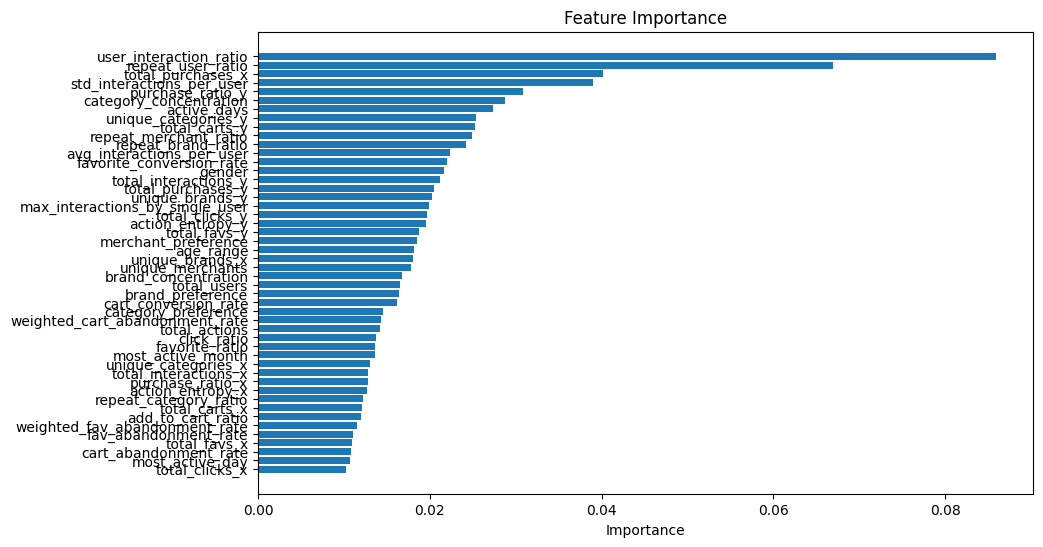

In [20]:
importances = xgb_model.feature_importances_

feature_names = train.drop(['label', 'user_id', 'merchant_id'], axis=1).columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [21]:
test['prob'] = final_ensemble_preds_weighted

# Prepare submission file
submission = test[['user_id', 'merchant_id', 'prob']]
submission.to_csv('prediction1.csv', index=False)
print("Submission file created.")

Submission file created.


# Neural Network

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

In [82]:
train = pd.read_csv('train.csv')[:10000]
test = pd.read_csv('test.csv')[:10000]

In [61]:
# Prepare data
X = train.drop(['label', 'user_id', 'merchant_id'], axis=1)

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
y = train['label']

X_test = test.drop(['user_id', 'merchant_id', 'prob'], axis=1)
X_test = imputer.transform(X_test)

scaler_full = StandardScaler()
X_scaled = scaler_full.fit_transform(X)
X_test_scaled = scaler_full.transform(X_test)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [56]:
# Convert training and test data to TensorDatasets
trainset = TensorDataset(torch.from_numpy(X_train).float(), 
                         torch.from_numpy(np.array(y_train)).float())
valset = TensorDataset(torch.from_numpy(X_val).float(), 
                        torch.from_numpy(np.array(y_val)).float())

# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)

In [57]:
# Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.output(x)
        return self.sigmoid(x)

# Initialize the model
input_dim = X_train.shape[1]

In [58]:
net = NeuralNetwork(input_dim)
# Define the cost / loss function
cost_fn = nn.BCELoss()

# Define the method of updating the weights each iteration (e.g. gradient descent)
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-5)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/200], Loss: 8.5293, AUROC: 0.5368
Epoch [2/200], Loss: 6.3381, AUROC: 0.6056
Epoch [3/200], Loss: 5.7381, AUROC: 0.7105
Epoch [4/200], Loss: 5.4748, AUROC: 0.7607
Epoch [5/200], Loss: 5.4128, AUROC: 0.7702
Epoch [6/200], Loss: 5.3023, AUROC: 0.7743
Epoch [7/200], Loss: 5.0950, AUROC: 0.8012
Epoch [8/200], Loss: 4.9511, AUROC: 0.8163
Epoch [9/200], Loss: 4.6430, AUROC: 0.8430
Epoch [10/200], Loss: 4.2324, AUROC: 0.8935
Epoch [11/200], Loss: 4.2866, AUROC: 0.8905
Epoch [12/200], Loss: 4.0034, AUROC: 0.9026
Epoch [13/200], Loss: 4.1505, AUROC: 0.8938
Epoch [14/200], Loss: 3.6711, AUROC: 0.9280
Epoch [15/200], Loss: 3.9536, AUROC: 0.9146
Epoch [16/200], Loss: 3.9143, AUROC: 0.8990
Epoch [17/200], Loss: 3.4388, AUROC: 0.9340
Epoch [18/200], Loss: 3.6648, AUROC: 0.9206
Epoch [19/200], Loss: 2.7187, AUROC: 0.9607
Epoch [20/200], Loss: 3.3386, AUROC: 0.9492
Epoch [21/200], Loss: 3.0900, AUROC: 0.9606
Epoch [22/200], Loss: 2.8097, AUROC: 0.9606
Epoch [23/200], Loss: 2.0084, AUROC: 0.98

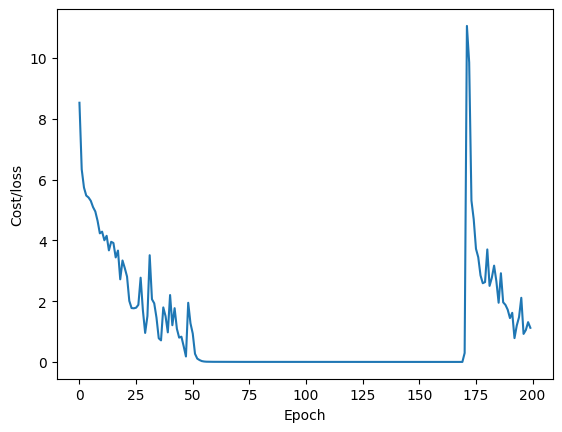

In [59]:
num_iter = 200
cost = []

net = net.to(device)
net.train() # Set the model to training mode

from sklearn.metrics import roc_auc_score

# Inside your training loop
for epoch in range(num_iter):
    running_loss = 0.0
    true_labels = []
    pred_probs = []

    for i, data in enumerate(trainloader):
        # Get the inputs X and labels y for the minibatch
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients of the weights each iteration
        optimizer.zero_grad()

        # Calculate the predictions and the cost/loss
        outputs = net(inputs).view(-1)  # Convert outputs to 1D array
        loss = cost_fn(outputs, labels)

        # Store true labels and predicted probabilities for AUROC
        true_labels.extend(labels.cpu().numpy())
        pred_probs.extend(outputs.cpu().detach().numpy())

        # Use autograd to calculate the gradient of the cost
        loss.backward()

        # Use the optimizer to update the weights
        optimizer.step()

        # Store the cost/loss
        running_loss += loss.item()

    # Calculate AUROC for the current epoch
    epoch_auroc = roc_auc_score(true_labels, pred_probs)
    print(f'Epoch [{epoch+1}/{num_iter}], Loss: {running_loss:.4f}, AUROC: {epoch_auroc:.4f}')

    cost.append(running_loss)
    
# After the loop, plot the loss
plt.plot(cost)
plt.xlabel('Epoch')
plt.ylabel('Cost/loss')
plt.show()


In [ ]:
net.eval()
with torch.no_grad():
    y_true = y_val.tolist()
    test_preds = []

    # Calculate the predictions on the validation set
    for data in valloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        probabilities = net(inputs)
        test_preds.extend(probabilities)

    # Calculate AUROC
    auroc = roc_auc_score(y_true, test_preds)
    print(f'Validation AUROC: {auroc:.4f}')


Validation AUROC: 0.5926


In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Neural Network Architecture with Dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.3):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_prob)  

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)  
        x = self.relu(self.layer2(x))
        x = self.dropout(x)  
        x = self.relu(self.layer3(x))
        x = self.dropout(x)  
        x = self.output(x)
        return self.sigmoid(x)

    

def prepare_data(X_train=None, y_train=None, X_val=None, y_val=None, X_test_scaled=None, test=False):
    """
    Prepares Data Loaders for Training , Testing and Validation.
    """
    
    if test:
        testset = TensorDataset(torch.from_numpy(X_test_scaled).float())  # Test set has no labels
        testloader = DataLoader(testset, batch_size=32, shuffle=False)

        return testloader
    
    else:
        # Convert training and validation data to TensorDatasets
        trainset = TensorDataset(torch.from_numpy(X_train).float(), 
                                torch.from_numpy(np.array(y_train)).float())
        valset = TensorDataset(torch.from_numpy(X_val).float(), 
                            torch.from_numpy(np.array(y_val)).float())
        
        # Create Dataloaders
        trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
        valloader = DataLoader(valset, batch_size=64, shuffle=False)
        
        return trainloader, valloader


def train_network(X_train, y_train, X_val, y_val):
    """
    Trains the Neural Network using weighted decay with Adam optimizer.
    """
    trainloader, valloader = prepare_data(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val) 
    input_dim = X_train.shape[1]
    net = NeuralNetwork(input_dim)

    # Define loss and optimizer
    cost_fn = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

    num_iter = 200
    net = net.to(device)
    cost_lst = []
    train_auroc_lst = []
    val_auroc_lst = []

    for epoch in range(num_iter):
        net.train()
        running_loss = 0.0
        true_labels = []
        pred_probs = []

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs).view(-1)  # Forward pass
            loss = cost_fn(outputs, labels)  # Loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            true_labels.extend(labels.cpu().numpy())
            pred_probs.extend(outputs.cpu().detach().numpy())

        train_auroc = roc_auc_score(true_labels, pred_probs)

        # Validate
        net.eval()
        val_true = []
        val_pred = []
        with torch.no_grad():
            for val_inputs, val_labels in valloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = net(val_inputs).view(-1)
                val_true.extend(val_labels.cpu().numpy())
                val_pred.extend(val_outputs.cpu().numpy())

        val_auroc = roc_auc_score(val_true, val_pred)
        print(f'Epoch [{epoch+1}/{num_iter}], Loss: {running_loss:.4f}, Train AUROC: {train_auroc:.4f}, Val AUROC: {val_auroc:.4f}')
        cost_lst.append(running_loss)
        train_auroc_lst.append(train_auroc)
        val_auroc_lst.append(val_auroc)
    
    return net, cost_lst, train_auroc, val_auroc


def predict_test(net, X_test_scaled):
    """
    Sets the trained neural network in eval mode to generate predictions on Test Data.
    """
    testloader = prepare_data(X_test_scaled=X_test_scaled, test=True)
    net.eval()
    test_preds = []

    with torch.no_grad():
        for inputs in testloader:
            inputs = inputs[0].to(device)  # Testloader yields inputs only (no labels)
            outputs = net(inputs).view(-1)
            test_preds.extend(outputs.cpu().numpy())

    return np.array(test_preds)



In [86]:
# Get predictions from Neural Network
net, cost_lst, train_auroc_lst, val_auroc_lst = train_network(X_train, y_train, X_val, y_val)

Epoch [1/200], Loss: 41.8815, Train AUROC: 0.5008, Val AUROC: 0.5888
Epoch [2/200], Loss: 31.0160, Train AUROC: 0.5638, Val AUROC: 0.5949
Epoch [3/200], Loss: 30.6807, Train AUROC: 0.5837, Val AUROC: 0.6018
Epoch [4/200], Loss: 30.2298, Train AUROC: 0.6019, Val AUROC: 0.5976
Epoch [5/200], Loss: 29.8881, Train AUROC: 0.6007, Val AUROC: 0.6065
Epoch [6/200], Loss: 29.3610, Train AUROC: 0.6306, Val AUROC: 0.6083
Epoch [7/200], Loss: 29.1017, Train AUROC: 0.6406, Val AUROC: 0.6080
Epoch [8/200], Loss: 28.8803, Train AUROC: 0.6483, Val AUROC: 0.6054
Epoch [9/200], Loss: 28.8066, Train AUROC: 0.6535, Val AUROC: 0.6005
Epoch [10/200], Loss: 29.0303, Train AUROC: 0.6465, Val AUROC: 0.6053
Epoch [11/200], Loss: 29.3412, Train AUROC: 0.6304, Val AUROC: 0.6030
Epoch [12/200], Loss: 28.9171, Train AUROC: 0.6438, Val AUROC: 0.5997
Epoch [13/200], Loss: 28.8186, Train AUROC: 0.6544, Val AUROC: 0.6003
Epoch [14/200], Loss: 28.8231, Train AUROC: 0.6483, Val AUROC: 0.5994
Epoch [15/200], Loss: 28.1970

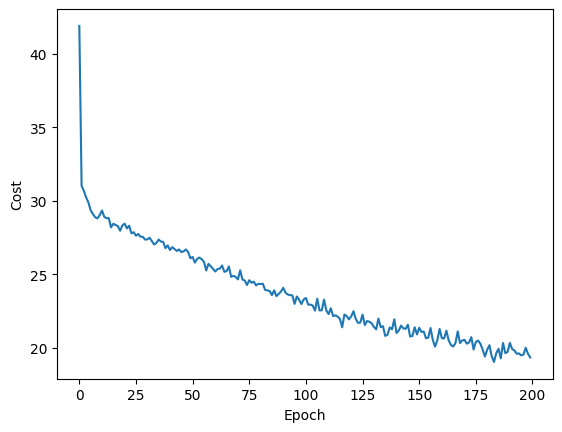

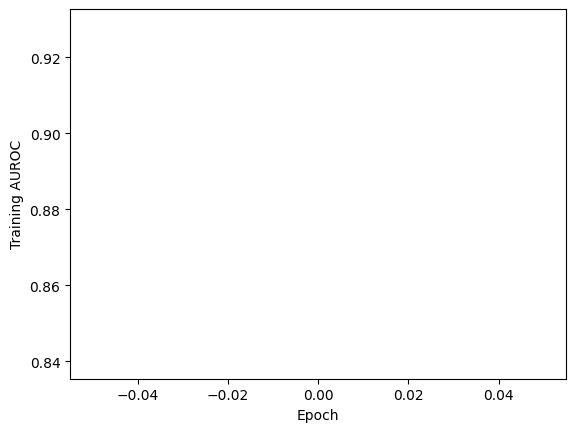

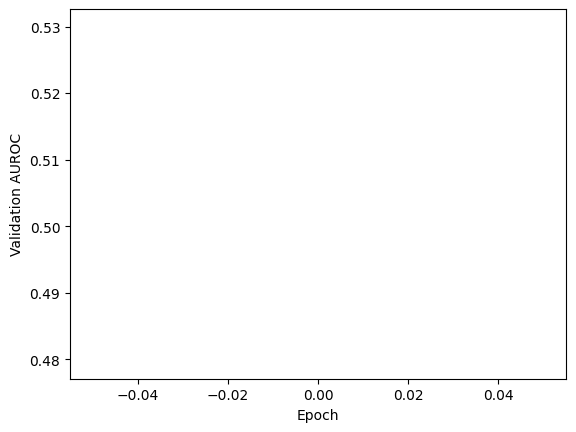

In [87]:
# After the loop, plot the loss
plt.plot(cost_lst)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

plt.plot(train_auroc_lst)
plt.xlabel('Epoch')
plt.ylabel('Training AUROC')
plt.show()

plt.plot(val_auroc_lst)
plt.xlabel('Epoch')
plt.ylabel('Validation AUROC')
plt.show()